In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import joblib
from CNN.utility import train_routine
from ds_creation.ds_utility import get_file_count, get_other_class
from ds_creation.split_config import phisical_split
from ds_creation.plot_utility import process_metrics
from prototypical.train.train_setup import train
from prototypical.model.loader import get_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TEST_SPLIT = 0.2

DATA_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test')
SPLIT_DIR = os.path.join('data', 'mammals_calls', 'splits', 'custom')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")

PATIENCE = 5
TO_TRAIN = False
FROM_START = True
os.makedirs(MODELS_METRICS_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
    
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Eseguo lo split fisico dei file solo la prima volta per dividere i file in train e test
FIRST_RUN = False
if FIRST_RUN:
    perc = 1-TEST_SPLIT
    phisical_split(DATA_DIR, perc)

2025-11-02 22:01:20.688301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 22:01:20.783237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 22:01:22.045006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Vengono divise le specie in tre gruppi:
* Quelle per il training della CNN, hanno più di 1000 sample, le restanti classi formeranno la classe other
* Quelle per il training della Prototypical, hanno tra i 1000 ed i 100 sample
* Quelle per il test della Prototypical, hanno meno di 100 sample 

Così vengono creati i file che serviranno alla prototypical per splittare le classi tra train, validation e test

In [2]:
count_df = get_file_count(DATA_DIR)

CNN_training = count_df[count_df['file_count'] >= 1000]['species'].tolist()
proto_training = count_df[(count_df['file_count'] <= 1000) & (count_df['file_count'] >= 100)]['species'].tolist()
proto_test = count_df[count_df['file_count'] < 100]['species'].tolist()

random.shuffle(proto_training)
split_idx = int(len(proto_training) * SPLIT_PERC['train'])
proto_train = proto_training[:split_idx]
proto_val = proto_training[split_idx:]
print(len(proto_train), len(proto_val), len(proto_test))
with open(os.path.join(SPLIT_DIR, 'test.txt'), 'w') as f:
    for species in proto_test:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'train.txt'), 'w') as f:
    for species in proto_train:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'val.txt'), 'w') as f:
    for species in proto_val:
        f.write(f"{species}\n")



14 4 21


Viene fisicamente generata la classe other, contenente i files di tutte le altre classi che hanno meno di 1000 sample.
Viene quindi avviato il training della CNN su queste classi con uno split train/val 80/20 per stabilire il numero di epoche ottimale per l'addestramento.

In [3]:
count_df_truncated = get_file_count(DATA_DIR)
count_df_truncated = count_df_truncated[count_df_truncated['file_count'] < 999]

other_species_list = count_df_truncated['species'].tolist()
print(f'Other total files: {count_df_truncated["file_count"].sum()}, species count: {count_df_truncated.shape}, species: {other_species_list}')
get_other_class(DATA_DIR, other_species_list)

count_df = get_file_count(DATA_DIR)

Other total files: 6000, species count: (39, 2), species: ['Common_Dolphin', 'White-sided_Dolphin', 'Walrus', 'Clymene_Dolphin', "Fraser's_Dolphin", 'False_Killer_Whale', 'Striped_Dolphin', 'West_Indian_Manatee', 'Ross_Seal', 'Northern_Right_Whale', "Grampus_Risso's_Dolphin", 'Harbor_Porpoise', 'Minke_Whale', 'Dusky_Dolphin', 'Atlantic_Spotted_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Leopard_Seal', 'Beluga_White_Whale', 'Melon_Headed_Whale', 'White-beaked_Dolphin', 'Gray_Whale', 'Harp_Seal', 'Southern_Right_Whale', 'Boutu_Amazon_River_Dolphin', 'Ribbon_Seal', "Heaviside's_Dolphin", "Dall's_Porpoise", 'Rough-Toothed_Dolphin', 'Spotted_Seal', 'Irawaddy_Dolphin', 'Narwhal', 'Ringed_Seal', 'Juan_Fernandez_Fur_Seal', 'Tucuxi_Dolphin', 'Hooded_Seal', 'Sea_Otter', 'Finless_Porpoise', 'Steller_Sea_Lion', 'New_Zealand_Fur_Seal']


In [4]:
# CNN training with all classes having at least 1000 samples
other_ds, history = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), cardinality=1000, subfolder='31-10_training', from_start=FROM_START, to_train=TO_TRAIN)

Total classes found: 13
h 164, w 397


I0000 00:00:1762120884.447346  870839 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 48 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


['Sperm_Whale', 'Fin_Finback_Whale', 'other', 'Humpback_Whale', 'Short-Finned_(Pacific)_Pilot_Whale', 'Bowhead_Whale', 'Killer_Whale', 'Bearded_Seal', 'Spinner_Dolphin', 'Long-Finned_Pilot_Whale', 'Pantropical_Spotted_Dolphin', 'Bottlenose_Dolphin', 'Weddell_Seal']


In [5]:
#CNN training with all classes
other_ds, history = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, len(count_df)), subfolder='02-11_training', from_start=FROM_START, to_train=TO_TRAIN)

Added classes: ['Sperm_Whale', 'Fin_Finback_Whale', 'other', 'Humpback_Whale', 'Short-Finned_(Pacific)_Pilot_Whale', 'Bowhead_Whale', 'Killer_Whale', 'Bearded_Seal', 'Spinner_Dolphin', 'Long-Finned_Pilot_Whale', 'Pantropical_Spotted_Dolphin', 'Bottlenose_Dolphin', 'Weddell_Seal', 'Common_Dolphin', 'White-sided_Dolphin', 'Walrus', 'Clymene_Dolphin', "Fraser's_Dolphin", 'False_Killer_Whale', 'Striped_Dolphin', 'West_Indian_Manatee', 'Ross_Seal', 'Northern_Right_Whale', "Grampus_Risso's_Dolphin", 'Harbor_Porpoise', 'Minke_Whale', 'Dusky_Dolphin', 'Atlantic_Spotted_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Leopard_Seal', 'Beluga_White_Whale', 'Melon_Headed_Whale', 'White-beaked_Dolphin', 'Gray_Whale', 'Harp_Seal', 'Southern_Right_Whale', 'Boutu_Amazon_River_Dolphin', 'Ribbon_Seal', "Heaviside's_Dolphin", "Dall's_Porpoise", 'Rough-Toothed_Dolphin', 'Spotted_Seal', 'Irawaddy_Dolphin', 'Narwhal', 'Ringed_Seal', 'Juan_Fernandez_Fur_Seal', 'Tucuxi_Dolphin', 'Hooded_Seal', 'Sea_Otter', 

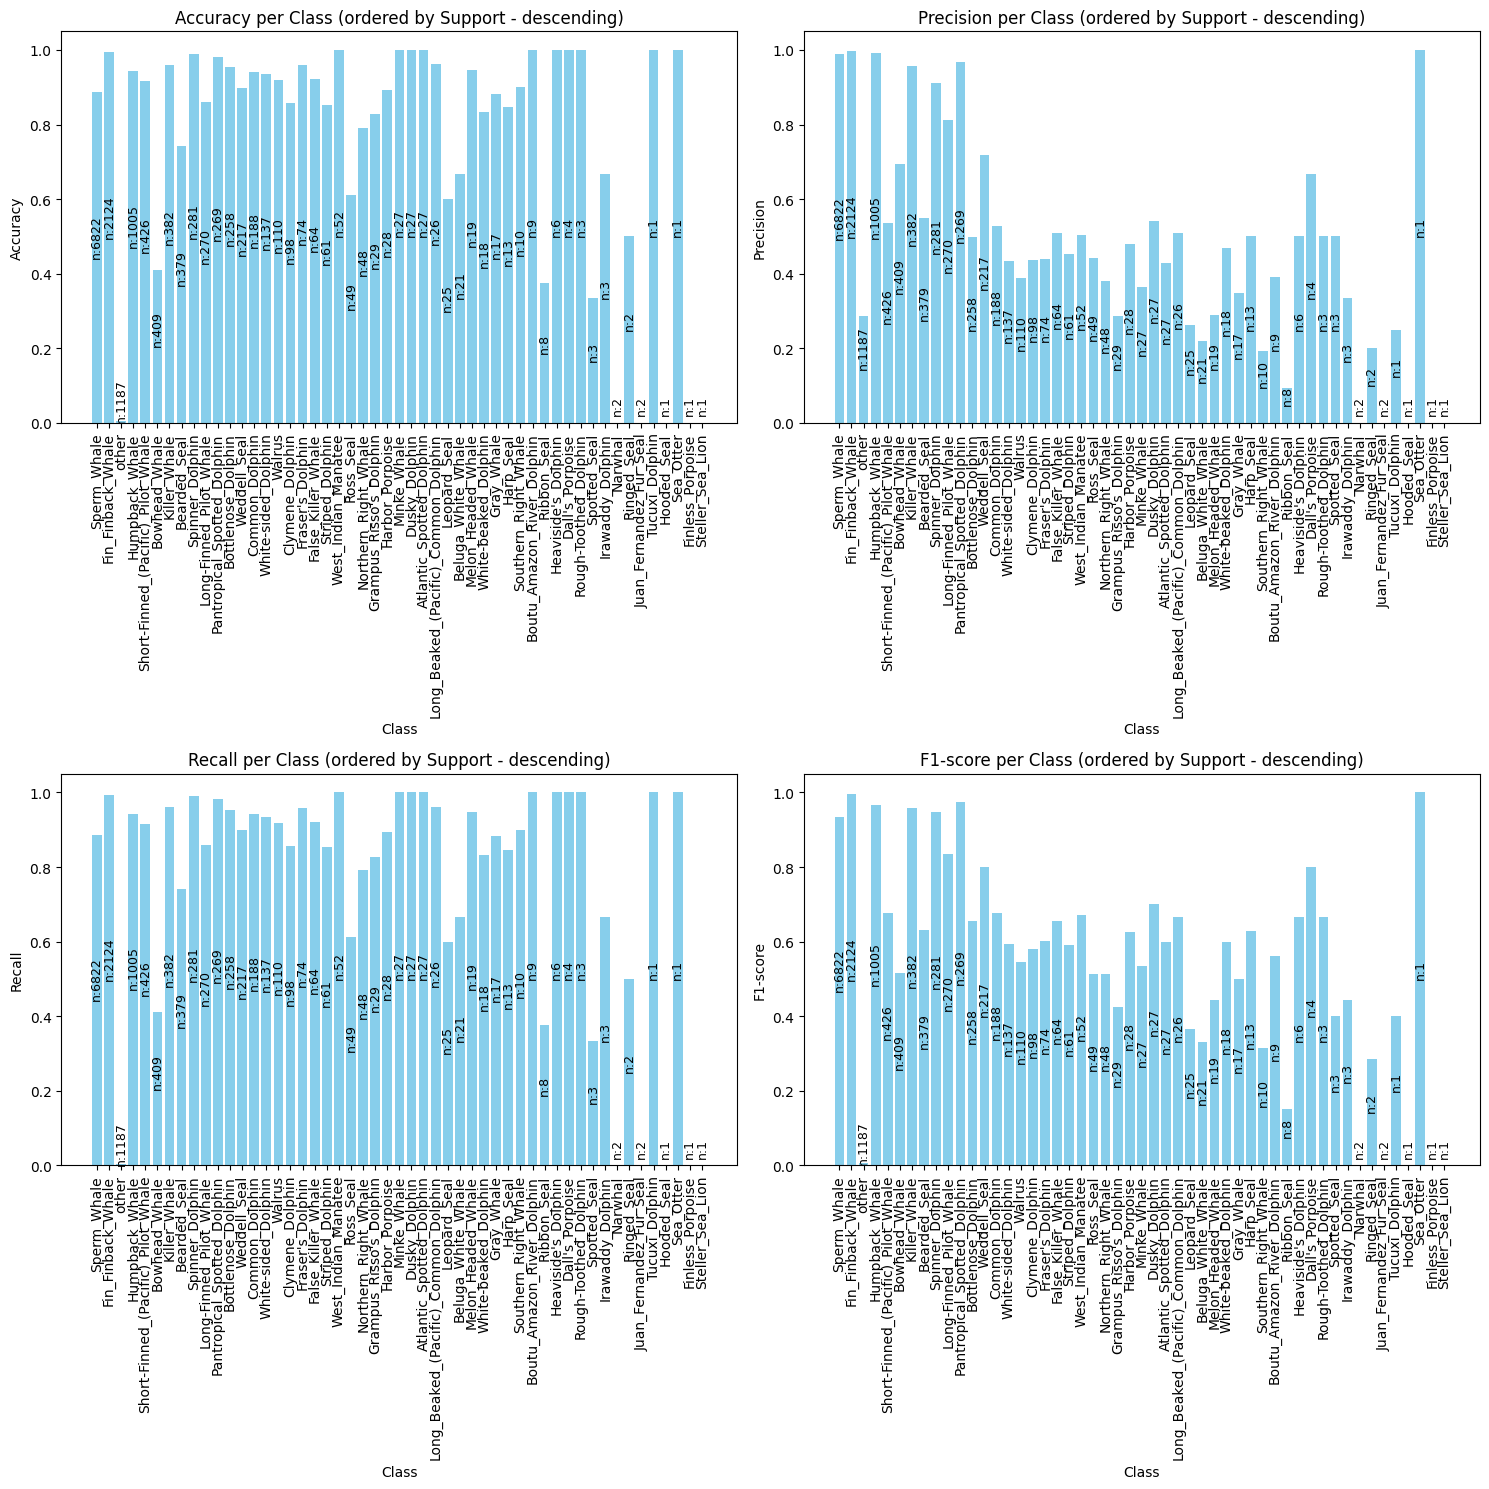

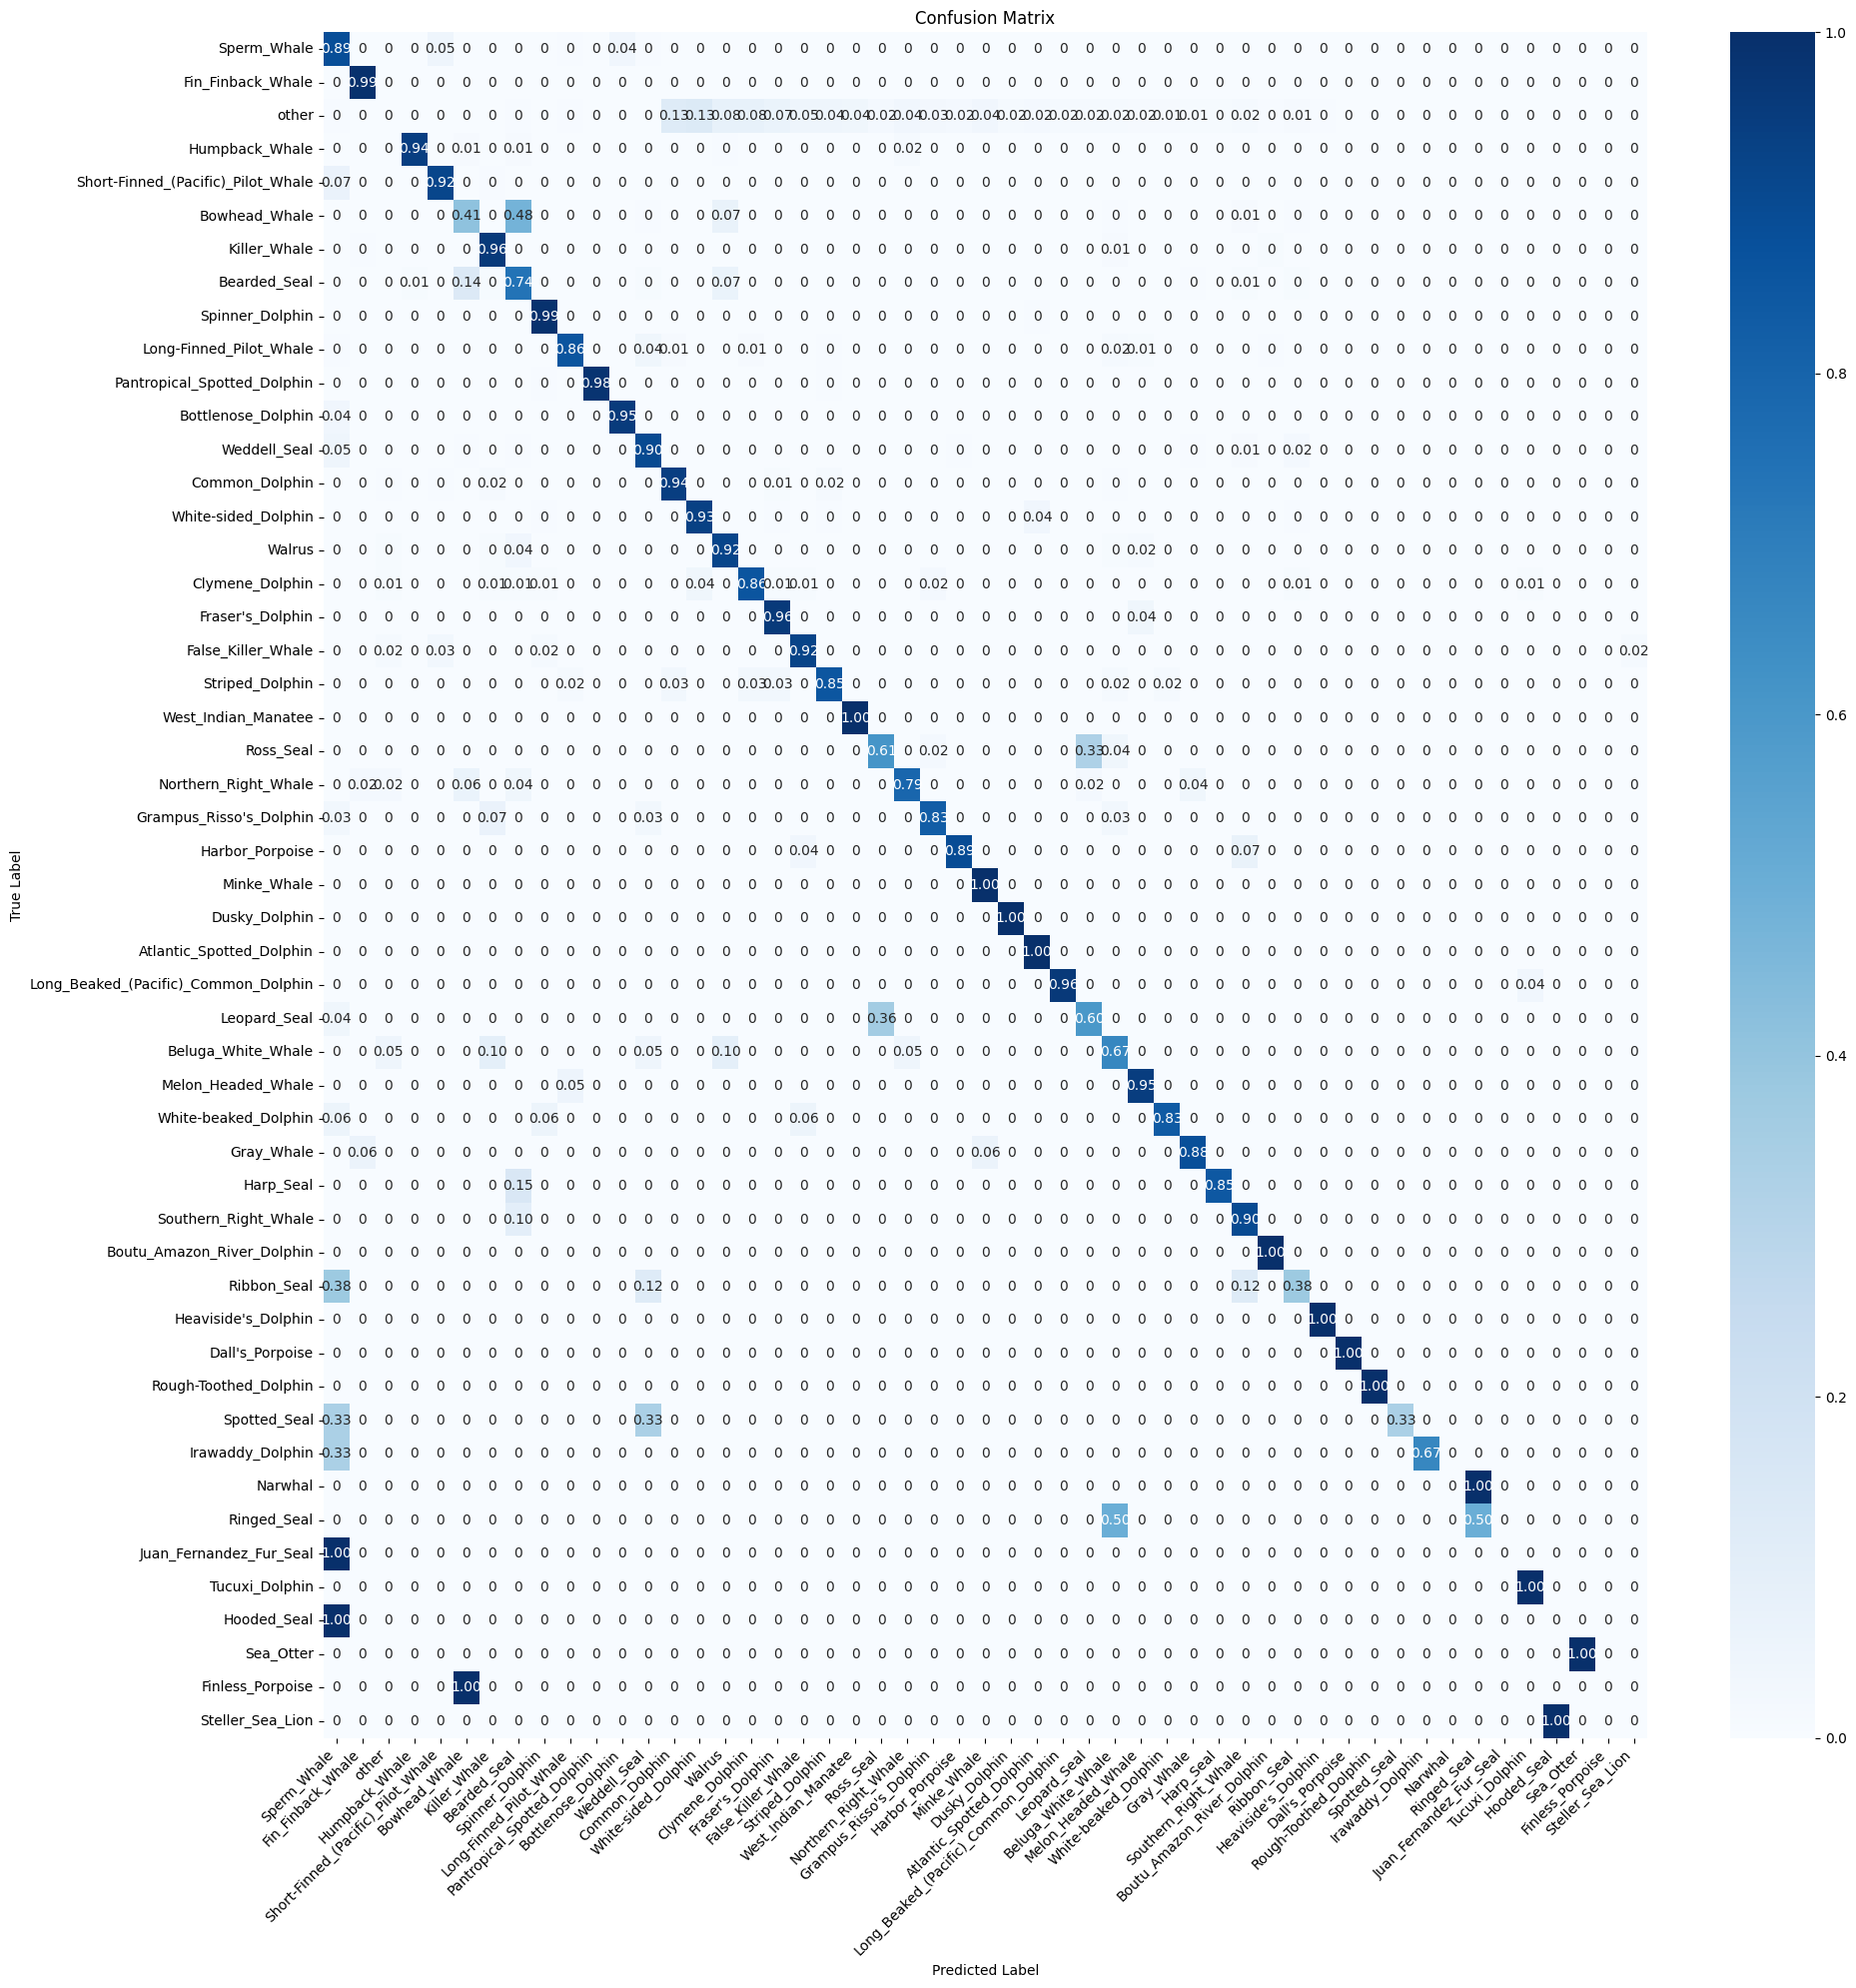

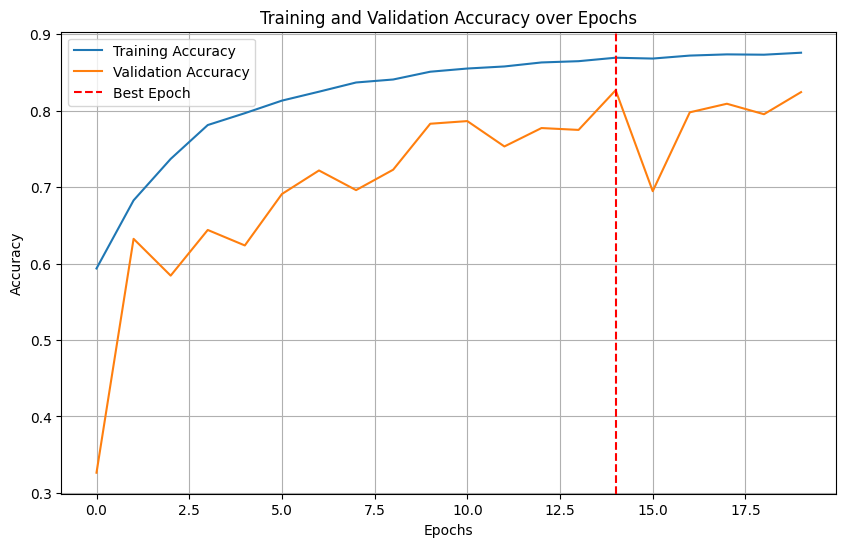

In [6]:
curr_training_date = '02-11'
process_metrics(count_df, 51, os.path.join(MODELS_METRICS_DIR, f'{curr_training_date}_training'), MODELS_METRICS_DIR)

## Proto Training

In [7]:
way = 4
support = 10
query = 5
config = {
    "data.dataset": "mammals_calls",
    "data.split": "custom",
    "data.train_way": way,
    "data.train_support": support,
    "data.train_query": query,
    "data.test_way": way,
    "data.test_support": support,
    "data.test_query": query,
    "data.episodes": 10,
    "data.gpu": 0,
    "data.cuda":True,
    "model.x_dim": "164,397,3",
    "model.z_dim": 64,
    "train.epochs": 50,
    'train.optim_method': "Adam",
    "train.lr": 0.001,
    "train.patience": 5,
    "model.save_path": 'data_cache/proto/test_mammals_calls.keras'
}

train(config)

Loaded 2 splits with 4 classes each.
Training started.
Epoch 1 started.
support shape: (4, 10, 164, 397, 3), query shape: (4, 5, 164, 397, 3)
x shape: (20, 96), y shape: (4, 96)
support shape: (4, 10, 164, 397, 3), query shape: (4, 5, 164, 397, 3)
x shape: (20, 96), y shape: (4, 96)


2025-11-02 22:02:08.180597: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.90MiB (rounded to 15625984)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-02 22:02:08.180623: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-11-02 22:02:08.180631: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 54, Chunks in use: 54. 13.5KiB allocated for chunks. 13.5KiB in use in bin. 4.6KiB client-requested in use in bin.
2025-11-02 22:02:08.180636: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-11-02 22:02:08.

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

way = 4
support = 5
query = 3
a = 0.7092592716217041

way = 4
support = 10
query = 5
a = 0.7827775478363037

In [ ]:
to_print = get_file_count(DATA_DIR)
print(to_print)

In [ ]:
classes = proto_val + proto_train + proto_test
n_support_dict = {curr_class: len(os.listdir(os.path.join(DATA_DIR, curr_class))) for curr_class in classes}
results = get_samples(classes, n_support_dict, {'w':w, 'h':h, 'c':3}, os.path.join('data_cache', 'proto', 'test_mammals_calls.keras'), DATA_DIR)

In [8]:
# prendo il csv con gli mfcc e aggiungo una colonna con il nome del file
mfcc_df = pd.read_pickle('audio_data.pkl')
mfcc_df['file_name'] = mfcc_df['audio_files'].apply(lambda x: os.path.basename(x))
mfcc_df = mfcc_df.drop(columns=['idx_gruppo'])
mfcc_df['species'] = mfcc_df['species'].apply(lambda x: x.replace(',', ''))

# specie presenti nei dataset di train
species = get_file_count(DATA_DIR)
species = species[species['file_count']<1000]['species'].tolist()

# creo un dataframe con i nomi dei file di ogni specie con cui fare training
train_files_dict = {species:os.listdir(os.path.join(DATA_DIR, species)) for species in species}
train_files_df = pd.DataFrame([(species, file) for species, files in train_files_dict.items() for file in files], columns=['species', 'file_name'])

# creo i dataframe finali di train unendo i due dataframe precedenti con il dataframe degli mfcc
train_df = pd.merge(train_files_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)


In [9]:
y_train = train_df['species']
y_mapping = {label:idx for idx, label in enumerate(y_train.unique())}
y_mapping_df = pd.DataFrame(list(y_mapping.items()), columns=['label', 'index'])
y_mapping_df.to_csv(os.path.join(MODELS_METRICS_DIR, 'label_to_index_forest.csv'), index=False)
y_train = y_train.map(y_mapping)

x_train = pd.DataFrame(train_df['chunk_list'].tolist())
x_train.columns = [f'mfcc_feature_{i}' for i in range(x_train.shape[1])]

pipeline_steps = [
    ('rf_classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
]

mfcc_pipeline = Pipeline(pipeline_steps)

mfcc_pipeline.fit(x_train, y_train)
joblib.dump(mfcc_pipeline, os.path.join(MODELS_METRICS_DIR, 'random_forest_mfcc_model.joblib'))



Inizio addestramento...
Addestramento completato!
